# Notebook overview

In this iteration, we will perform a supervised classification based on image and using the previously tested pre-trained ResNet50 CNN that showed quite good results.

We will follow the following workflow:

1. Prepare image files folder architecture.
2. Split image into training, validation and testing sets.
3. Preprocess images with the built-in ResNet50 method
4. Set up data augmentation
5. Train different classification layer setups keeping convolution layers frozen.
6. Fine-tuning by unfreezing progressively convolution layers.

# Imports

## Libraries

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import time, os, random, math, shutil, importlib
from os import listdir
import itertools
import utils
importlib.reload(utils)

# sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from skimage import io

# keras
import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential
from keras.preprocessing.image import load_img, img_to_array
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, Rescaling, RandomFlip, RandomRotation, RandomZoom

import mlflow.tensorflow

# settings
pd.set_option('display.max_colwidth', 150)
pd.options.display.float_format = '{:.4f}'.format

sns.set_style('whitegrid', {'grid.linewidth': .05, 'grid.color': '.85'})
sns.set_palette('Set2')

## Data

In [152]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0000,899.0000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curta...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0000,449.0000,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Sel...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self D..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL S...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0000,1299.0000,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SAN...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed...""]",BDSEJTHNGWVGWWQU,2599.0000,698.0000,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Flora

# Preparing data

## Extract and encode category

As in the previous iterations, we will extract the main category and encode it with LabelEncoder

In [153]:
df['category'] = df['product_category_tree'].apply(lambda x: utils.extract_category(x, 0))
df.sample(10)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category
376,15f45d08050e8ba24a14804cba000589,2015-12-01 06:13:00 +0000,http://www.flipkart.com/denver-hamilton-pride-combo-set/p/itme7cjvcer5nr8b?pid=CAGE7CJVGGHQYZDQ,Denver Hamilton Pride Combo Set,"[""Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Denver Combos""]",CAGE7CJVGGHQYZDQ,379.0000,370.0000,15f45d08050e8ba24a14804cba000589.jpg,False,Flipkart.com: Buy Denver Hamilton Pride Combo Set online only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of Contents in Set"", ""value""=>""2""}, {""key""=>""Combo Set Content"", ""value""=>""1Black Code For Men 1 Hamilt...",Beauty and Personal Care
538,3864ab10ef7006452fef45513de8f868,2016-01-07 05:50:25 +0000,http://www.flipkart.com/sonata-7092sl01-yuva-analog-watch-men/p/itmda5wabnyfzq2w?pid=WATDA5ZABPHZZV3Q,Sonata 7092SL01 Yuva Analog Watch - For Men,"[""Watches >> Wrist Watches >> Sonata Wrist Watches""]",WATDA5ZABPHZZV3Q,999.0000,999.0000,3864ab10ef7006452fef45513de8f868.jpg,True,Sonata 7092SL01 Yuva Analog Watch - For Men - Buy Sonata 7092SL01 Yuva Analog Watch - For Men 7092SL01 Online at Rs.999 in India Only at Flipka...,4.3,4.3,NaN,"{""product_specification""=>[{""key""=>""Type"", ""value""=>""Analog""}, {""key""=>""Series"", ""value""=>""Yuva""}, {""key""=>""Style Code"", ""value""=>""7092SL01""}, {""k...",Watches
739,52877a6306aef18af67ab54c8233c931,2016-04-21 16:46:08 +0000,http://www.flipkart.com/buyer-s-beach-bb349/p/itmehwgrbga2pqdh?pid=CNSEHWGRNCSHGNPC,Buyer's Beach BB349,"[""Kitchen & Dining >> Dinnerware & Crockery >> Cups & Saucers >> Buyer's Beach Cups & Saucers >> Buyer's Beach BB349 (Brown)""]",CNSEHWGRNCSHGNPC,999.0000,449.0000,52877a6306aef18af67ab54c8233c931.jpg,False,"Buyer's Beach BB349 (Brown) Price: Rs. 449 Stylish In Every Discernment, These Multicolor Cups Will Procure An Individual Boundless Compliments Fr...",No rating available,No rating available,Buyer's Beach,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Buyer's Beach""}, {""key""=>""Model Number"", ""value""=>""BB349""}, {""key""=>""Type"", ""value""=>""Tea""},...",Kitchen & Dining
315,e93cd13f5269dd51b8359ccf93ca5ace,2015-12-01 06:13:00 +0000,http://www.flipkart.com/denver-ro-black-code-gift-set-combo/p/itme7czrhhazqgkj?pid=CAGE7CZR6ZD9RT3K,"Denver RO,Black Code Gift Set Combo Set","[""Beauty and Personal Care >> Fragrances >> Deodorants >> Combos >> Denver Combos""]",CAGE7CZR6ZD9RT3K,360.0000,355.0000,e93cd13f5269dd51b8359ccf93ca5ace.jpg,False,"Flipkart.com: Buy Denver RO,Black Code Gift Set Combo Set online only for Rs. 355 from Flipkart.com. Only Genuine Products. 30 Day Replacement Gu...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Gift Set Content"", ""value""=>""1 RO Deo Spray For Men""}, {""key""=>""Number of Contents in Set"", ""value""=>""2""}, {""k...",Beauty and Personal Care
790,75549ef6adc47e9b6dc2b69f530d9097,2015-12-12 11:46:53 +0000,http://www.flipkart.com/luba-hf45-stylo-analog-watch-men/p/itme9mxphrg7ydes?pid=WATE9MXPJRBNAM8T,LUBA HF45 Stylo Analog Watch - For Men,"[""Watches >> Wrist Watches >> LUBA Wrist Watches""]",WATE9MXPJRBNAM8T,775.0000,265.0000,75549ef6adc47e9b6dc2b69f530d9097.jpg,False,LUBA HF45 Stylo Analog Watch - For Men - Buy LUBA HF45 Stylo Analog Watch - For Men HF45 Online at Rs.265 in India Only at Flipkart.com. - Grea...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograph"", ""value""=>""No""}, {""key""=>""Altimeter"", ""value""=>""No""}, {""key""=>""Date Display"", ""value""=>""No""}, {""k...",Watches
382,4c449766e715bc41023244c9042e0a82,2015-12-01 06:13:00 +0000,http://www.flipkart.com/vincent-valent

In [154]:
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['category'])
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-multicolor-abstract-eyelet-door-curtain/p/itmeg7bkzdgthcts?pid=CRNEG7BKMFFYHQ8Z,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,"[""Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...""]",CRNEG7BKMFFYHQ8Z,1899.0000,899.0000,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curta...",No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""...",Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-towel/p/itmegfzhxbyucwgn?pid=BTWEGFZHGBXPHZUH,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Sathiyas Baby Bath Towels >> Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Y...""]",BTWEGFZHGBXPHZUH,600.0000,449.0000,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,"Specifications of Sathiyas Cotton Bath Towel (3 Bath Towel, Red, Yellow, Blue) Bath Towel Features Machine Washable Yes Material Cotton Design Sel...",No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Material"", ""value""=>""Cotton""}, {""key""=>""Design"", ""value""=>""Self D...",Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-face-towel-set/p/itmeg6shbrpubhca?pid=BTWEG6SHXTDB2A2Y,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath Towels >> Eurospa Baby Bath Towels >> Eurospa Cotton Terry Face Towel Set (20 PIECE FA...""]",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,"Key Features of Eurospa Cotton Terry Face Towel Set Size: small Height: 9 inch GSM: 360,Eurospa Cotton Terry Face Towel Set (20 PIECE FACE TOWEL S...",No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"", ""value""=>""Cotton Terry""}, {""key""=>""Design"", ""value""=>""SHUVAM""}, {""key""=>""Brand"", ""value""=>""Eurospa""...",Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-cotton-printed-king-sized-double-bedsheet/p/itmejt9uaqahahuf?pid=BDSEJT9UQWHDUBH4,SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> SANTOSH ROYAL FASHION Bedsheets >> SANTOSH ROYAL FASHION Cotton Printed King sized ...""]",BDSEJT9UQWHDUBH4,2699.0000,1299.0000,d4684dcdc759dd9cdf41504698d737d8.jpg,False,"Key Features of SANTOSH ROYAL FASHION Cotton Printed King sized Double Bedsheet Royal Bedsheet Perfact for Wedding & Gifting,Specifications of SAN...",No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""SANTOSH ROYAL FASHION""}, {""key""=>""Machine Washable"", ""value""=>""Yes""}, {""key""=>""Type"", ""value...",Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-floral-king-sized-double-bedsheet/p/itmejthnwahrnt7v?pid=BDSEJTHNGWVGWWQU,Jaipur Print Cotton Floral King sized Double Bedsheet,"[""Home Furnishing >> Bed Linen >> Bedsheets >> Jaipur Print Bedsheets >> Jaipur Print Cotton Floral King sized Double Bed...""]",BDSEJTHNGWVGWWQU,2599.0000,698.0000,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,"Key Features of Jaipur Print Cot

In [155]:
categories_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
categories_mapping

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

## Clean dataset

In [156]:
data = df.copy()
data = data[['image', 'category', 'label']]
data.sample(5)

,image,category,label
136,73f460cd6f3fd206902d7097a1816405.jpg,Kitchen & Dining,5
131,de911421573d3e234450040374b55b38.jpg,Kitchen & Dining,5
79,320833ab08c9a94ef83520612899a85f.jpg,Baby Care,0
820,00d84a518e0550612fcfcba3b02b6255.jpg,Beauty and Personal Care,1
611,e0e261a0d4fd2ffdcbcad324e91a0dd4.jpg,Home Furnishing,4


## Train and test split

It is important to have a robust way to evaluate the performance of the neural networks and deep learning models, therefore the data must be split in training and test set. 
We will start by splitting manually the data in train (0.8) and test (0.2) sets preserving stratification. We will then use Keras dataset utility to separate a portion of the training data into a validation dataset and evaluate the performance of the model on that validation dataset in each epoch.

To avoid confusion between validation and test sets: 
- a validation dataset is a sample of data held back from training the model that is used to give an estimate of it;
- a test dataset is also held back from the training of the model, but is instead used to give an unbiased estimate of the skill of the final tuned model when comparing or selecting between final models

In [157]:
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['label'], random_state=42)
print(train_df.shape)
print(test_df.shape)

(840, 3)
(210, 3)


In [158]:
train_df['label'].value_counts()

label
4    120
2    120
5    120
0    120
3    120
1    120
6    120
Name: count, dtype: int64

In [159]:
test_df['label'].value_counts()

label
0    30
1    30
4    30
6    30
3    30
5    30
2    30
Name: count, dtype: int64

Thanks to stratification, we get exactly 120 train set images per category for training and 30 images per category for final estimation.

## Create folder architecture

In order to use the keras Dataset utilities, we will have to create a specific folder structure to store the image files, each subfolder should correspond to the label in this way:

```
image_folder/
    train/
        class 0/ 
            image 1
            image 2
            image 2
            
        class 1/ 
        class 2/
        class 3/
        ...
    test/
        class 0/ 
            image 1
            image 2
            image 2
            
        class 1/ 
        class 2/
        class 3/
        ...
```


In [160]:
images_path = 'Flipkart/Images'
train_images_path = './data/train'
test_images_path = './data/test'

In [161]:
os.path.isdir(train_images_path)

True

In [162]:
def create_dataset_folders(df, target_folder_path):
    """
    Creates a folder for each label and copies files to it

    Input:
        df: dataframe containing image paths and labels
        target_folder_path: string, pathname of the target folder (train, test)

    Output:
        void
    """

    # remove folder if exists
    if os.path.isdir(target_folder_path):
        shutil.rmtree(target_folder_path)

    # create the target folder
    os.makedirs(target_folder_path)

    for index, row in df.iterrows():
        label_directory = target_folder_path + '/' + str(row['label'])
    
        if not os.path.exists(label_directory):
           os.makedirs(label_directory)
        
        current_image_path = images_path + '/' + row['image']
        new_image_path = label_directory + '/' + row['image']
    
        shutil.copyfile(current_image_path, new_image_path)

Copy train dataset

In [163]:
create_dataset_folders(train_df, train_images_path)

subfolders_train = [f for f in os.listdir(train_images_path) if not f.startswith('.')]
subfolders_train = sorted(subfolders_train)
subfolders_train

['0', '1', '2', '3', '4', '5', '6']

In [164]:
for folder in subfolders_train:
    files = [f for f in os.listdir(train_images_path + '/' + folder) if not f.startswith('.')]

    print(f'class {folder}: {len(files)} images')

class 0: 120 images
class 1: 120 images
class 2: 120 images
class 3: 120 images
class 4: 120 images
class 5: 120 images
class 6: 120 images


Copy test dataset

In [165]:
create_dataset_folders(test_df, test_images_path)

subfolders_test = [f for f in os.listdir(test_images_path) if not f.startswith('.')]
subfolders_test = sorted(subfolders_test)
subfolders_test

['0', '1', '2', '3', '4', '5', '6']

In [166]:
for folder in subfolders_test:
    files = [f for f in os.listdir(test_images_path + '/' + folder) if not f.startswith('.')]

    print(f'class {folder}: {len(files)} images')

class 0: 30 images
class 1: 30 images
class 2: 30 images
class 3: 30 images
class 4: 30 images
class 5: 30 images
class 6: 30 images


**Check images**

Baby Care


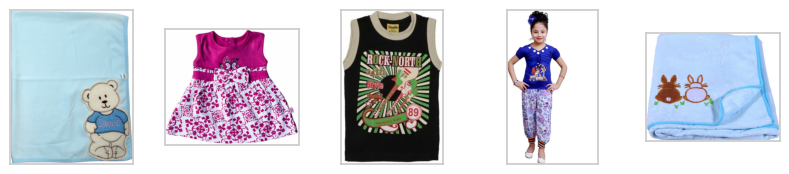

Beauty and Personal Care


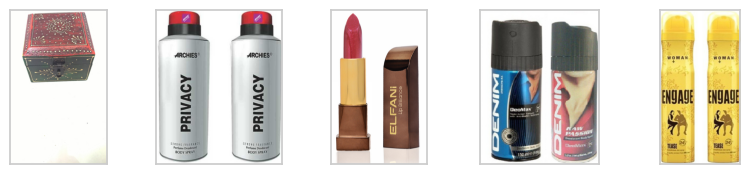

Computers


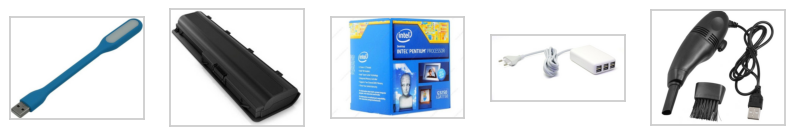

Home Decor & Festive Needs


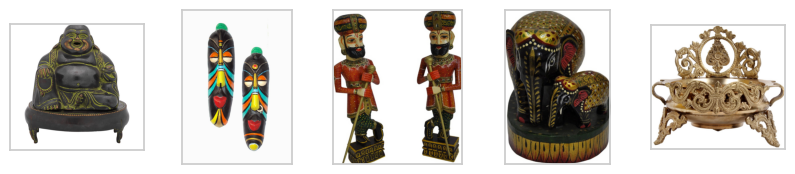

Home Furnishing


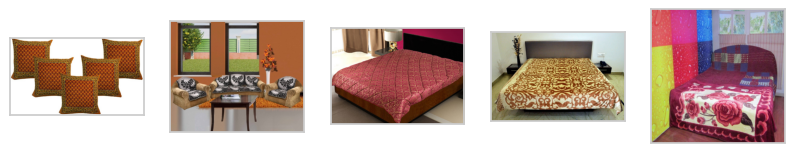

Kitchen & Dining


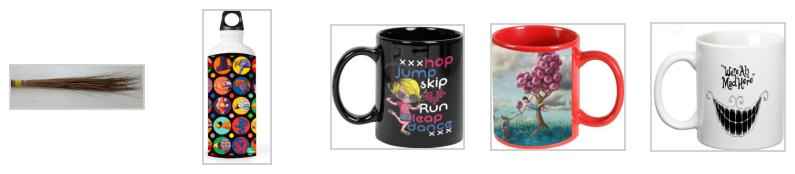

Watches


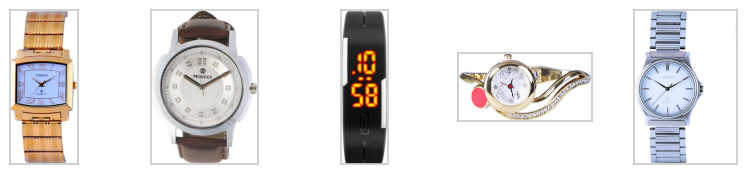

In [167]:
for folder in subfolders_train:
    image_folder = train_images_path + '/' + folder
    images = [f for f in os.listdir(image_folder) if not f.startswith('.')][:5]
    sample_images = []
    
    # read images
    for image in images:
        image = io.imread(image_folder + '/' + image)
        sample_images.append(image)

    print(f'{categories_mapping[int(folder)]}')
    utils.display_images(X=sample_images, columns=5, x_size=1, y_size=1)

## Generate Datasets

We will now use the Keras Dataset utility to load 3 datasets (training, validation and test) from the images in the folders, 80% for the training data and 20% for the validation

In [223]:
batch_size = 32
img_height = 224
img_width = 224

training_ds = keras.utils.image_dataset_from_directory(
                    train_images_path, labels='inferred', label_mode='int',
                    batch_size=batch_size, image_size=(img_width, img_height), shuffle=True, seed=42,
                    validation_split=0.2, subset='training'
                    )

Found 840 files belonging to 7 classes.
Using 672 files for training.


In [224]:
validation_ds = keras.utils.image_dataset_from_directory(
                    train_images_path, labels='inferred', label_mode='int',
                    batch_size=batch_size, image_size=(img_width, img_height), shuffle=True, seed=42,
                    validation_split=0.2, subset='validation'
                    )

Found 840 files belonging to 7 classes.
Using 168 files for validation.


In [225]:
test_ds = tf.keras.utils.image_dataset_from_directory(
                    test_images_path, labels='inferred', label_mode='int',
                    batch_size=batch_size, image_size=(img_width, img_height),
                    validation_split=0, subset=None, shuffle=False
                    )

Found 210 files belonging to 7 classes.


In [226]:
class_names = training_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6']


## Preprocess images

Each Keras model expects a specific kind of input preprocessing. For ResNet, the `tf.keras.applications.resnet.preprocess_input` should be called on the inputs before passing them to the model. `resnet.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

In [172]:
def preprocess(images, labels):
  return preprocess_input(images), labels

Apply the preprocessing function on training, validation and test datasets

In [227]:
training_ds = training_ds.map(preprocess)
validation_ds = validation_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## Data augmentation

As we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

We will apply the following transformations:

- a horizontal random flip
- a random rotation
- a random zoom

In [228]:
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

These layers are active only during training when calling Model.fit. 

Test Data Augmentation defined above on a random image:

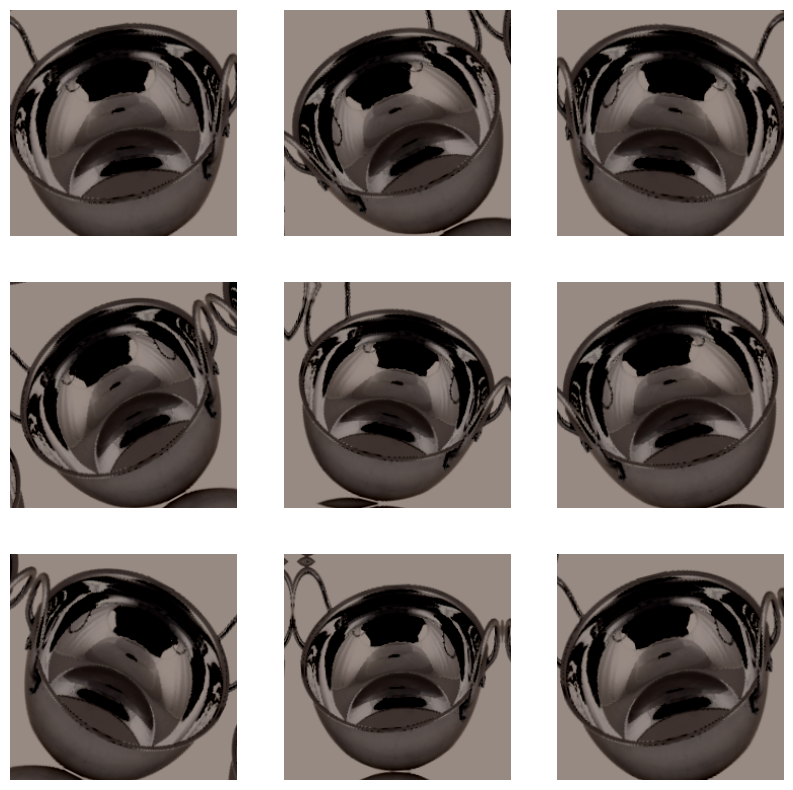

In [229]:
for image, _ in training_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Feature extraction

We will use the representations learned by ResNet50 CNN to extract meaningful features from our data. The ResNet50 showed good results in the previous iteration on the unsupervised classification, so we'll use it again. We will add a new classifier on top of the pretrained model because the one used by the pretrained model is specific to the original classification task and to the data on which it was trained. This way we can repurpose the feature maps learned previously for the dataset.

We will use the following steps:

1. Load the pretrained base model, freeze the convolutional layers.
2. Compose the main model by chaining an input pipeline with data augmentation, the base model, classification layers
3. Compile the model
4. Define callbacks
5. Train the model
6. Evaluate the model

## Create the base model

We will instantiate the base model with the same parameters:

- weights: 'imagenet'
- include_top: False -> keep only convolutional layers as we will include the specific layers for the classification
- input_shape: (224, 224, 3)

It is important to freeze the convolutional base before we compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. 

In [230]:
base_resnet_model = ResNet50(weights = 'imagenet', include_top = False, input_shape=(img_width, img_height, 3))

# Freeze existing ResNet already trained weights
base_resnet_model.trainable = False

for layer in base_resnet_model.layers:
    print(f'{layer.name} trainable: {layer.trainable}')


input_8 trainable: False
conv1_pad trainable: False
conv1_conv trainable: False
conv1_bn trainable: False
conv1_relu trainable: False
pool1_pad trainable: False
pool1_pool trainable: False
conv2_block1_1_conv trainable: False
conv2_block1_1_bn trainable: False
conv2_block1_1_relu trainable: False
conv2_block1_2_conv trainable: False
conv2_block1_2_bn trainable: False
conv2_block1_2_relu trainable: False
conv2_block1_0_conv trainable: False
conv2_block1_3_conv trainable: False
conv2_block1_0_bn trainable: False
conv2_block1_3_bn trainable: False
conv2_block1_add trainable: False
conv2_block1_out trainable: False
conv2_block2_1_conv trainable: False
conv2_block2_1_bn trainable: False
conv2_block2_1_relu trainable: False
conv2_block2_2_conv trainable: False
conv2_block2_2_bn trainable: False
conv2_block2_2_relu trainable: False
conv2_block2_3_conv trainable: False
conv2_block2_3_bn trainable: False
conv2_block2_add trainable: False
conv2_block2_out trainable: False
conv2_block3_1_conv tra

In [231]:
base_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_8[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

Now we need to connect our pretrained model with data preprocessing layers and new layers for classification.

We will start by setting batch_size to 16 and epochs number to 10 to find the best model setup and then fine-tune these parameters with the help of **MLFlow**

We will include a Dropout layer after the Dense layers, the Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1/(1 - rate) such that the sum over all inputs is unchanged.

The model structure will be as follows:

<u> 1st configuration: 1 dense layer of 256 nodes </u>
1. Data augmentation layer
2. Conv layers from ResNet50 model
3. Average pooling layer
4. Dense layer to convert the features into a single prediction per image, 256 nodes
5. Dropout layer 0.5
6. Dense layer 7 (for number of categories)

Validation Accuracy :  0.84 <br/>
Validation Loss     :  0.57 <br/>
Test Accuracy       :  0.81 <br/>
Test Loss           :  0.6 <br/>
Execution time      :  555.8423 seconds

<u> 2nd configuration: dense layer 256 + dense layer 128
1. Data augmentation layer
2. Conv layers from ResNet50 model
3. Average pooling layer
4. Dense layer, 256 nodes
5. Dropout layer 0.2
6. Dense layer, 128 nodes
7. Dropout layer 0.5
8. Dense layer 7

Validation Accuracy :  0.85 <br/>
Validation Loss     :  0.51 <br/>
Test Accuracy       :  0.82 <br/>
Test Loss           :  0.6 <br/>
Execution time      :  484 seconds (stopping at 26)

<u> 3d configuration: dense layer with 512 nodes </u>
1. Data augmentation layer
2. Conv layers from ResNet50 model
3. Average pooling layer
4. Dense layer 512 nodes
5. Dropout layer 0.5
6. Dense layer 7

Validation Accuracy :  0.83 <br/>
Validation Loss     :  0.57 <br/>
Test Accuracy       :  0.81 <br/>
Test Loss           :  0.59 <br/>
Execution time      : 561 seconds (early stopping at 21)

**Define the model**

<u>Activation functions </u>

Activation functions introduce an additional step at each layer during the forward propagation, their primary role is to transform the summed weighted input from the node into an output value to be fed to the next hidden layer or as output. Activation functions add non-linearity to the neural network.

We will use the 'ReLu' activation function for the hidden layer and 'softmax' for the output layer.

**ReLU** stands for Rectified Linear Unit. It does not activate all the neurons at the same time, the neurons will only be activated if the output of the linear transformation is more than 0, `f(x) = max(0, x)`. Because of this the ReLU function is far more computationally efficient when compared to the sigmoid and tanh functions.

**Softmax** function is most commonly used as an activation function for the last layer of the neural network in the case of multi-class classification. The softmax function is described as a combination of multiple sigmoids, it calculates the relative probabilities of each class.

In [232]:
# Define the model
resnet_model = Sequential([
                    data_augmentation,
                    base_resnet_model,
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu'),
                    Dropout(0.2),
                    Dense(128, activation='relu'),
                    Dropout(0.5),
                    Dense(7, activation='softmax')
                ])

Compile the model before training it with 'sparse_categorical_crossentropy' loss function which works for targets encoded with integers, 'adam' optimizer with 0.0001 learning rate (for transfer learning it is recommended to use a very low learning rate because we don’t want to change too much what is previously learned)

In [233]:
# Compile the model
resnet_model.compile(loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.0001), 
    metrics=["accuracy"])
resnet_model.build((None, img_width, img_height, 3)) 
resnet_model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 256)               524544    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                     

## Define callbacks

We will use the `ModelCheckpoint` callback in order to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [234]:
best_model_save_path = "./models/resnet_model_best_weights.h5"
best_model_cb = ModelCheckpoint(best_model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

We will also use the `EarlyStopping` callback to stop the training when a monitored metric has stopped improving.

In [235]:
early_stopping_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

## Train the model

Batch size: It is recommended to use a number of batch size with powers of 2 (8, 16, 32, 64, 128, etc) because it fits with the memory of the computer. We will start by a batch size of 16 and 10 epochs, then increase them progressively and monitor the resulting vac accuracy and val loss with the help of MLFlow.

In [182]:
mlflow.tensorflow.autolog()

In [236]:
start = time.time()

batch_size = 16
epochs = 30

history = resnet_model.fit(training_ds,
                    validation_data=validation_ds,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[best_model_cb, early_stopping_cb], 
                    verbose=1)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

2023/10/24 08:58:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '106b57b286ac403298ba2331dea18a63', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 2.3182 - accuracy: 0.1741
Epoch 1: val_loss improved from inf to 1.58864, saving model to ./models/resnet_model_best_weights.h5
21/21 [==============================] - 20s 831ms/step - loss: 2.3182 - accuracy: 0.1741 - val_loss: 1.5886 - val_accuracy: 0.4405
Epoch 2/30


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 1.8448 - accuracy: 0.2872
Epoch 2: val_loss improved from 1.58864 to 1.34259, saving model to ./models/resnet_model_best_weights.h5
21/21 [==============================] - 18s 802ms/step - loss: 1.8448 - accuracy: 0.2872 - val_loss: 1.3426 - val_accuracy: 0.6429
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 1.4974 - accuracy: 0.4613
Epoch 3: val_loss improved from 1.34259 to 1.12807, saving model to ./models/resnet_model_best_weights.h5
21/21 [==============================] - 18s 800ms/step - loss: 1.4974 - accuracy: 0.4613 - val_loss: 1.1281 - val_accuracy: 0.6964
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 1.3113 - accuracy: 0.5387
Epoch 4: val_loss improved from 1.12807 to 0.90525, saving model to ./models/resnet_model_best_weights.h5
21/21 [==============================] - 18s 811ms/step - loss: 1.3113 - accuracy: 0.5387 - val_loss: 0.9053 - val_accuracy: 0.7500
Epoch 5/30
21/2

INFO:tensorflow:Assets written to: /var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/tmp8ys1r_en/model/data/model/assets


execution time: 484.1433 seconds


In [237]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.8571


In [185]:
def display_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']}):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        
        for c in curves:
            plt.plot(history.history[c])
            
        plt.legend(curves, loc='upper left')
        plt.show()

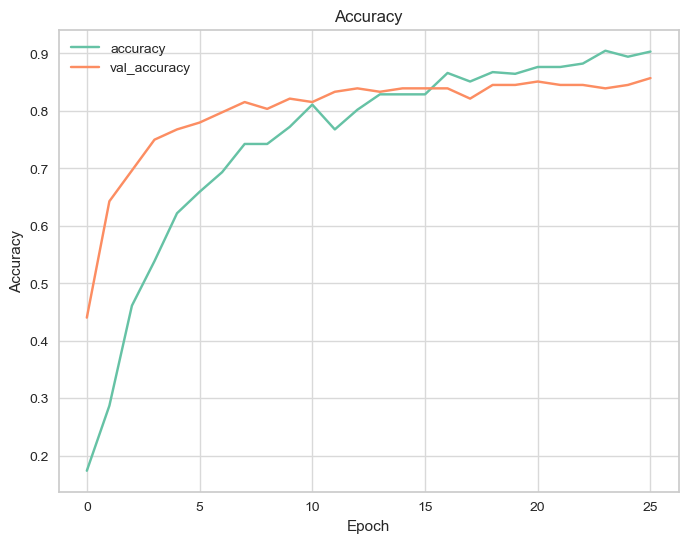

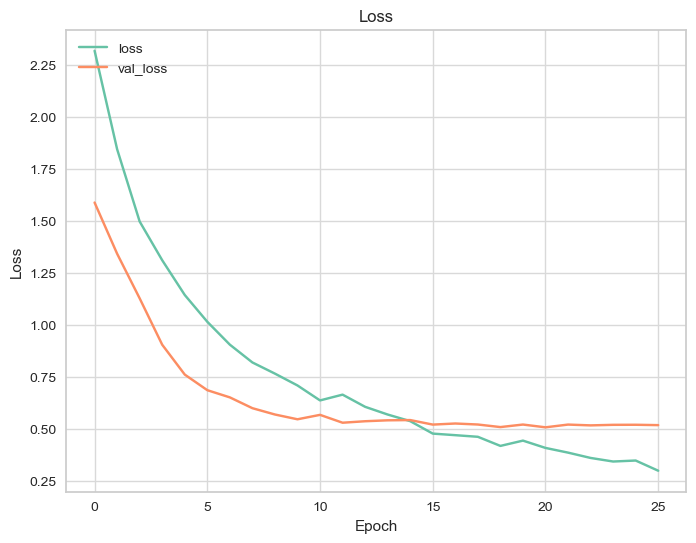

In [238]:
display_history(history)

From the accuracy plot we can notice that the validation accuracy reaches high values rather quickly (from 6th epoch) and then stagnates from 18 to 26th epoch. The early stopping occured on the 26th epoch. At about 14 - 15th epochs the validation accuracy reaches the accuracy score, the accuracy curve then goes higher and the validation occuracy stays almost the same, we can observe a slight overfit.

## Evaluate

It is time now to use the test set to evaluate the performance of the model:

In [240]:
resnet_model.load_weights(best_model_save_path)

loss, accuracy = resnet_model.evaluate(validation_ds, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Loss :  {:.4f}".format(loss))

loss, accuracy = resnet_model.evaluate(test_ds, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss       :  {:.4f}".format(loss))

Validation Accuracy :  0.8512
Validation Loss :  0.5084
Test Accuracy       :  0.8238
Test Loss       :  0.5983


We get 0.85 validation accuracy and much lower test accuracy, and a lower validation loss compared to test loss which looks normal.

Let's use the confusion matrix to check the performance of each category prediction:

In [188]:
def display_confusion_matrix(y_true, y_pred, label_names, normalize='true'):
    """
    Calculates and displays confusion matrix

    Input:
        y_true: array of true labels
        y_pred: array of predicted labels
        label_names: names of the classes

    Output:
        void
    """

    if (normalize == 'true'):
        print('Recall')

    if (normalize == 'pred'):
        print('Precision')
    
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=label_names)
    disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='vertical')

    plt.grid(False)
    plt.show()

In [241]:
y_pred = resnet_model.predict(test_ds)
y_pred

7/7 [==============================] - 4s 543ms/step


array([[8.1920320e-01, 1.3436090e-03, 1.9490234e-04, ..., 1.7897095e-01,
        4.2523578e-05, 2.5858375e-05],
       [1.4682148e-01, 4.3829285e-02, 2.5339800e-01, ..., 3.4834710e-01,
        3.1412799e-02, 1.6298110e-02],
       [5.9161919e-01, 1.2653552e-02, 3.4559328e-02, ..., 8.7962098e-02,
        4.1932482e-02, 3.4248747e-03],
       ...,
       [5.3971480e-03, 1.0246017e-02, 2.9338005e-03, ..., 7.9850368e-03,
        8.2672881e-03, 9.5593864e-01],
       [7.4784103e-04, 1.1491587e-03, 3.1328990e-04, ..., 3.1280342e-05,
        1.4658642e-03, 9.9530631e-01],
       [2.4720736e-02, 4.8352548e-01, 5.2596029e-02, ..., 9.5057506e-03,
        9.5047809e-02, 3.1330940e-01]], dtype=float32)

In [242]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 4, 0, 0, 4, 5, 4, 2, 4, 4, 3, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 3, 3, 0, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 4, 1, 1, 6, 1, 2, 1, 1, 4, 1, 2, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 6, 3, 2, 2, 2, 2, 2,
       3, 2, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 3, 3, 3, 3, 3, 3, 2, 1, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1])

In [243]:
y_true = np.concatenate([y for x, y in test_ds])
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int32)

In [244]:
categories = [categories_mapping[key] for key in categories_mapping]

Recall


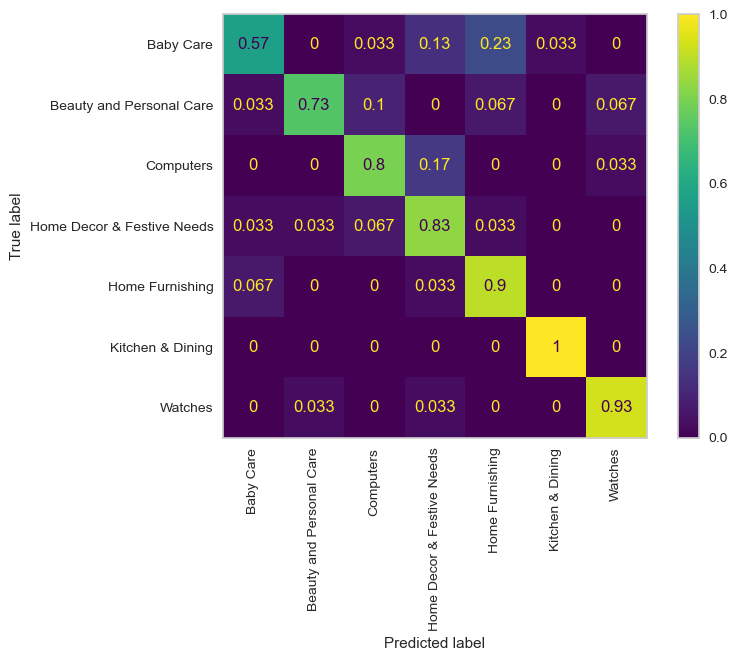

In [245]:
display_confusion_matrix(y_true, y_pred, label_names=categories)

In our case of multi-class classification, recall metric stands for the percentage of products belonging to a category that were predicted with the same category (true positive rate). We notice that 100% of Kitchen and Dining were correctly identified and only 57% of Baby Care were predicted correctly.

Precision


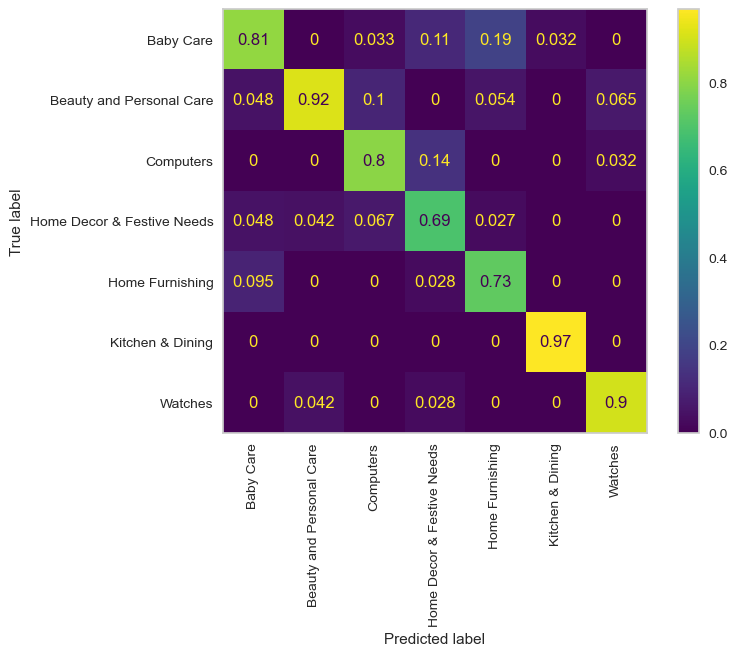

In [246]:
display_confusion_matrix(y_true, y_pred, label_names=categories, normalize='pred')

Precision stands for: out of all products predicted with a category, what percentage really belongs to this category. For example, we notice that for the 'Watches' category, 90% are really watches and some products from 'Beauty and Personal Care' and 'Computers' were also identified as 'Watches'. We obtain the best precision for the 'Kitchen & Dining'. 

It is not obvious to decide which of the metrics, recall or precision matters more for the project, therefore we will check the F1 score that combines both of them.

In [247]:
print(metrics.classification_report(y_true, y_pred, target_names=categories))

                            precision    recall  f1-score   support

                 Baby Care       0.81      0.57      0.67        30
  Beauty and Personal Care       0.92      0.73      0.81        30
                 Computers       0.80      0.80      0.80        30
Home Decor & Festive Needs       0.69      0.83      0.76        30
           Home Furnishing       0.73      0.90      0.81        30
          Kitchen & Dining       0.97      1.00      0.98        30
                   Watches       0.90      0.93      0.92        30

                  accuracy                           0.82       210
                 macro avg       0.83      0.82      0.82       210
              weighted avg       0.83      0.82      0.82       210



The Kitchen & Dining category has the best F1 score. The Baby Care is the least successful category, we can notice a confusion with Home Furnishing products.

# Fine-tuning

In the previous step we used the convolutional layers of ResNet50 without updating the weights. We will unfreeze a few of the top layers of a frozen model base and jointly train both the newly-added classifier layers and the last layers of the base model. This will force the weights to be tuned from generic feature maps to features associated specifically with out dataset.

## Unfreeze the last block
### Update the model

The base model has 175 layers, we will start by freezing the conv5 block layers at the end (32 layers)

In [248]:
base_resnet_model.trainable = True

for layer in base_resnet_model.layers[:143]:
    layer.trainable = False

# Check if the layers have been correctly unfrozen
for layer in base_resnet_model.layers:
    print(f'{layer.name} trainable: {layer.trainable}')

input_8 trainable: False
conv1_pad trainable: False
conv1_conv trainable: False
conv1_bn trainable: False
conv1_relu trainable: False
pool1_pad trainable: False
pool1_pool trainable: False
conv2_block1_1_conv trainable: False
conv2_block1_1_bn trainable: False
conv2_block1_1_relu trainable: False
conv2_block1_2_conv trainable: False
conv2_block1_2_bn trainable: False
conv2_block1_2_relu trainable: False
conv2_block1_0_conv trainable: False
conv2_block1_3_conv trainable: False
conv2_block1_0_bn trainable: False
conv2_block1_3_bn trainable: False
conv2_block1_add trainable: False
conv2_block1_out trainable: False
conv2_block2_1_conv trainable: False
conv2_block2_1_bn trainable: False
conv2_block2_1_relu trainable: False
conv2_block2_2_conv trainable: False
conv2_block2_2_bn trainable: False
conv2_block2_2_relu trainable: False
conv2_block2_3_conv trainable: False
conv2_block2_3_bn trainable: False
conv2_block2_add trainable: False
conv2_block2_out trainable: False
conv2_block3_1_conv tra

Compile the model and set a lower learning rate than in the previous step

In [249]:
resnet_model.compile(loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001),
    metrics=["accuracy"])
resnet_model.build((None, img_width, img_height, 3)) 
resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 256)               524544    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                     

### Define callbacks

In [250]:
best_model_unfrozen1_save_path = "./models/resnet_model_unfrozen1_best_weights.h5"
best_model_unfrozen1_cb = ModelCheckpoint(best_model_unfrozen1_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [251]:
early_stopping_unfrozen1_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

### Train the model

In [252]:
start = time.time()

history_unfrozen1 = resnet_model.fit(training_ds,
                    validation_data=validation_ds,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[best_model_unfrozen1_cb, early_stopping_unfrozen1_cb], 
                    verbose=1)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

2023/10/24 09:11:01 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '92182d4864954692959e3826be4ce2ff', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.7946
Epoch 1: val_loss improved from inf to 0.51537, saving model to ./models/resnet_model_unfrozen1_best_weights.h5
21/21 [==============================] - 27s 1s/step - loss: 0.6179 - accuracy: 0.7946 - val_loss: 0.5154 - val_accuracy: 0.8452
Epoch 2/30


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.5282 - accuracy: 0.8363
Epoch 2: val_loss did not improve from 0.51537
21/21 [==============================] - 24s 1s/step - loss: 0.5282 - accuracy: 0.8363 - val_loss: 0.5220 - val_accuracy: 0.8393
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.4713 - accuracy: 0.8571
Epoch 3: val_loss did not improve from 0.51537
21/21 [==============================] - 24s 1s/step - loss: 0.4713 - accuracy: 0.8571 - val_loss: 0.5248 - val_accuracy: 0.8333
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.4487 - accuracy: 0.8542
Epoch 4: val_loss did not improve from 0.51537
21/21 [==============================] - 24s 1s/step - loss: 0.4487 - accuracy: 0.8542 - val_loss: 0.5179 - val_accuracy: 0.8333
Epoch 5/30
21/21 [==============================] - ETA: 0s - loss: 0.3957 - accuracy: 0.8765
Epoch 5: val_loss improved from 0.51537 to 0.51093, saving model to ./models/resnet_model_unfrozen1_best_we

INFO:tensorflow:Assets written to: /var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/tmpesrygqv7/model/data/model/assets


execution time: 433.1924 seconds


In [253]:
max_val_accuracy_unfrozen1 = max(history_unfrozen1.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy_unfrozen1))

Max validation accuracy is : 0.8512


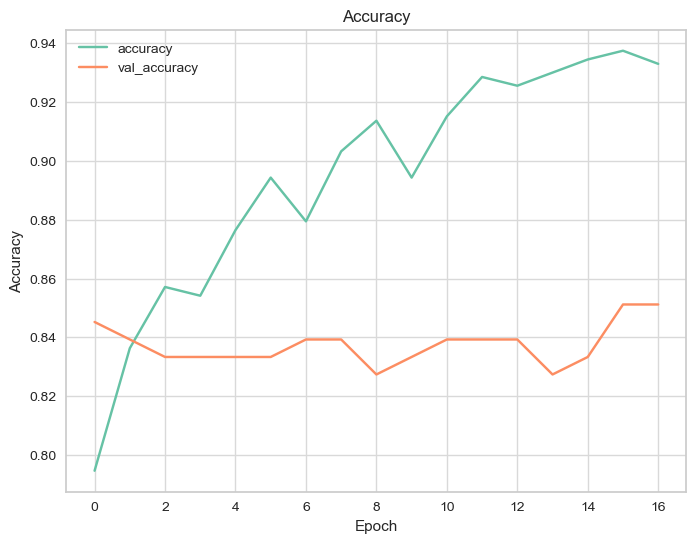

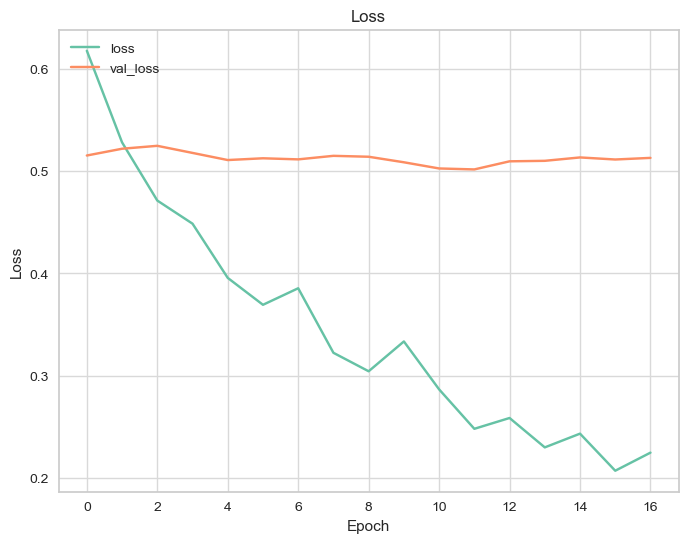

In [254]:
display_history(history_unfrozen1)

We get higher accuracy scores for the training and validation sets but we observe an increasing overfit between those scores, which is higher than in the previous step with frozen layers, same for the loss scores.

### Evaluate

In [255]:
resnet_model.load_weights(best_model_unfrozen1_save_path)

loss, accuracy = resnet_model.evaluate(validation_ds, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation Loss :  {:.4f}".format(loss))

loss, accuracy = resnet_model.evaluate(test_ds, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss :  {:.4f}".format(loss))

Validation Accuracy :  0.8393
Validation Loss :  0.5018
Test Accuracy       :  0.8333
Test Loss :  0.5385


We notice a small improvemet in the test accuracy (from 0.82 to 0.83) and a lower test loss (from 0.6 to 0.54). Validation accuracy went from 0.85 to 0.84 but validation loss was improved from 0.51 to 0.5.

In [256]:
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

7/7 [==============================] - 4s 544ms/step


array([0, 2, 0, 0, 4, 5, 3, 2, 4, 4, 3, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       3, 0, 0, 0, 0, 0, 4, 0, 2, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 4, 1, 1, 6, 1, 2, 1, 1, 3, 1, 5, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2,
       3, 5, 3, 3, 0, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1])

Recall


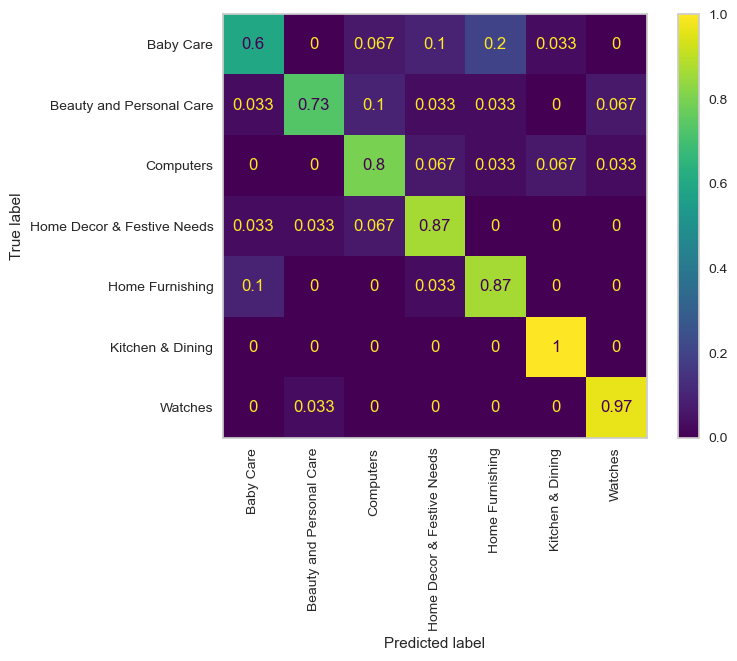

In [257]:
display_confusion_matrix(y_true, y_pred, label_names=categories)

It is interesting to notice that some categories like 'Watches' improved the Recall (from 0.93 to 0.97), and others got a lower ratio (Home furnishing passed from 0.9 to 0.87)

Precision


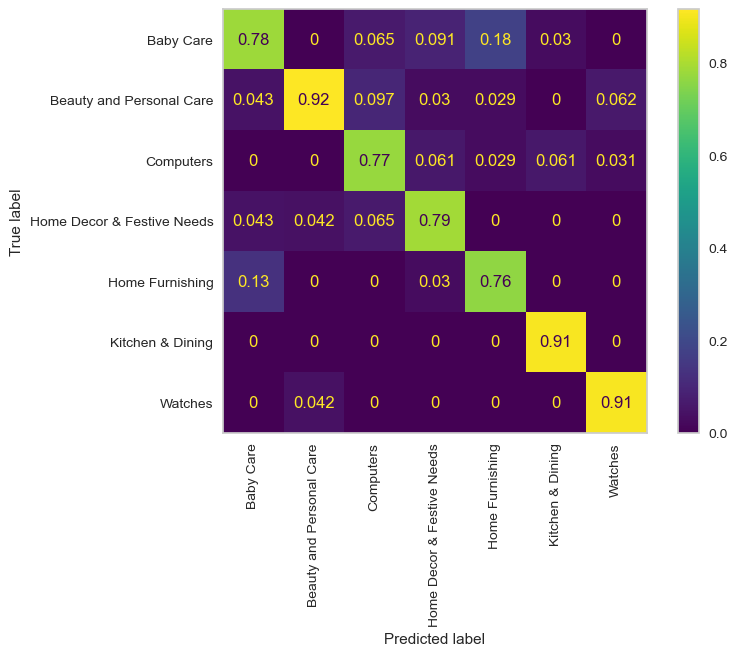

In [258]:
display_confusion_matrix(y_true, y_pred, label_names=categories, normalize='pred')

In [259]:
print(metrics.classification_report(y_true, y_pred, target_names=categories))

                            precision    recall  f1-score   support

                 Baby Care       0.78      0.60      0.68        30
  Beauty and Personal Care       0.92      0.73      0.81        30
                 Computers       0.77      0.80      0.79        30
Home Decor & Festive Needs       0.79      0.87      0.83        30
           Home Furnishing       0.76      0.87      0.81        30
          Kitchen & Dining       0.91      1.00      0.95        30
                   Watches       0.91      0.97      0.94        30

                  accuracy                           0.83       210
                 macro avg       0.83      0.83      0.83       210
              weighted avg       0.83      0.83      0.83       210



Overall, training the weights of the last block of convolutional layers produced a slightly better performance but it also introduces a higher overfit.

## Unfreeze 2 last blocks

Let's continue the fine-tuning with unfreezing more convolutional layers.

### Update the model

The block 4 of conv layers is composed of 62 layers, so we need to freeze 81 layers

In [260]:
base_resnet_model.trainable = True

for layer in base_resnet_model.layers[:81]:
    layer.trainable = False

# Check if the layers have been correctly unfrozen
for layer in base_resnet_model.layers:
    print(f'{layer.name} trainable: {layer.trainable}')

input_8 trainable: False
conv1_pad trainable: False
conv1_conv trainable: False
conv1_bn trainable: False
conv1_relu trainable: False
pool1_pad trainable: False
pool1_pool trainable: False
conv2_block1_1_conv trainable: False
conv2_block1_1_bn trainable: False
conv2_block1_1_relu trainable: False
conv2_block1_2_conv trainable: False
conv2_block1_2_bn trainable: False
conv2_block1_2_relu trainable: False
conv2_block1_0_conv trainable: False
conv2_block1_3_conv trainable: False
conv2_block1_0_bn trainable: False
conv2_block1_3_bn trainable: False
conv2_block1_add trainable: False
conv2_block1_out trainable: False
conv2_block2_1_conv trainable: False
conv2_block2_1_bn trainable: False
conv2_block2_1_relu trainable: False
conv2_block2_2_conv trainable: False
conv2_block2_2_bn trainable: False
conv2_block2_2_relu trainable: False
conv2_block2_3_conv trainable: False
conv2_block2_3_bn trainable: False
conv2_block2_add trainable: False
conv2_block2_out trainable: False
conv2_block3_1_conv tra

In [261]:
# Compile the model
resnet_model.compile(loss="sparse_categorical_crossentropy", 
    optimizer=keras.optimizers.legacy.Adam(learning_rate=0.00001), 
    metrics=["accuracy"])
resnet_model.build((None, img_width, img_height, 3)) 
resnet_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_21 (Dense)            (None, 256)               524544    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                     

### Define callbacks

In [262]:
best_model_unfrozen2_save_path = "./models/resnet_model_unfrozen2_best_weights.h5"
best_model_unfrozen2_cb = ModelCheckpoint(best_model_unfrozen2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [263]:
early_stopping_unfrozen2_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

### Train the model

In [264]:
start = time.time()

history_unfrozen2 = resnet_model.fit(training_ds,
                    validation_data=validation_ds,
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[best_model_unfrozen2_cb, early_stopping_unfrozen2_cb], 
                    verbose=1)

exec_time = round((time.time() - start), 4)
print(f'execution time: {exec_time} seconds')

2023/10/24 09:22:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ec496960638f42f78c6d52cd759c3005', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.3269 - accuracy: 0.9033
Epoch 1: val_loss improved from inf to 0.49839, saving model to ./models/resnet_model_unfrozen2_best_weights.h5
21/21 [==============================] - 38s 2s/step - loss: 0.3269 - accuracy: 0.9033 - val_loss: 0.4984 - val_accuracy: 0.8393
Epoch 2/30


/Users/natche/opt/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/21 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.9033
Epoch 2: val_loss did not improve from 0.49839
21/21 [==============================] - 35s 2s/step - loss: 0.3270 - accuracy: 0.9033 - val_loss: 0.4994 - val_accuracy: 0.8333
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2430 - accuracy: 0.9375
Epoch 3: val_loss improved from 0.49839 to 0.49655, saving model to ./models/resnet_model_unfrozen2_best_weights.h5
21/21 [==============================] - 34s 2s/step - loss: 0.2430 - accuracy: 0.9375 - val_loss: 0.4966 - val_accuracy: 0.8274
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9390
Epoch 4: val_loss did not improve from 0.49655
21/21 [==============================] - 34s 2s/step - loss: 0.2163 - accuracy: 0.9390 - val_loss: 0.4982 - val_accuracy: 0.8155
Epoch 5/30
21/21 [==============================] - ETA: 0s - loss: 0.2388 - accuracy: 0.9196
Epoch 5: val_loss did not improve from

INFO:tensorflow:Assets written to: /var/folders/vr/99kbccc17nq3k76_w_1rrznr0000gn/T/tmptaiq40l5/model/data/model/assets


execution time: 300.5157 seconds


In [265]:
max_val_accuracy_unfrozen2 = max(history_unfrozen2.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy_unfrozen2))

Max validation accuracy is : 0.8393


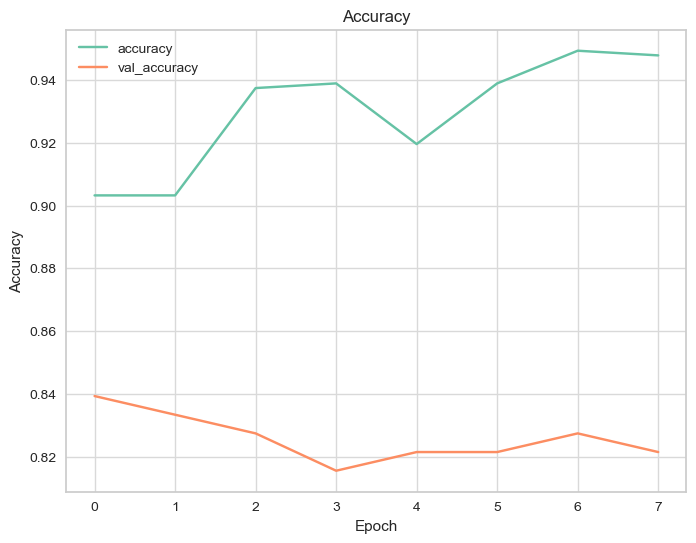

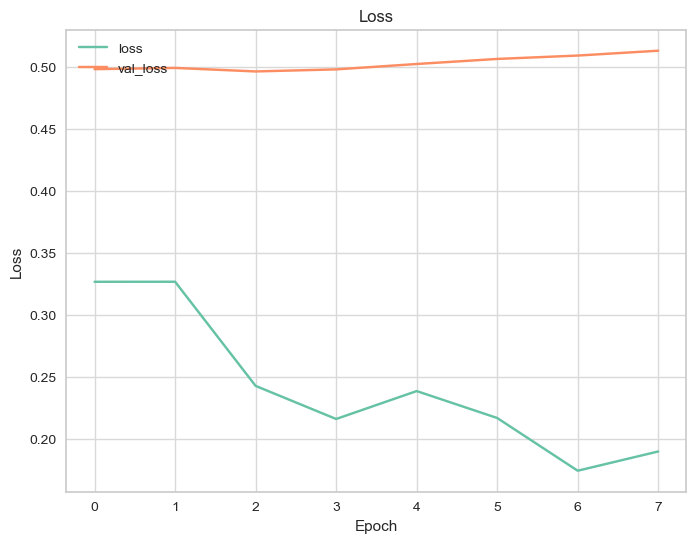

In [266]:
display_history(history_unfrozen2)

As in the previous step, we can still notice a quite high overfit issue when comparing the training and validation accuracies.

### Evaluate

In [267]:
resnet_model.load_weights(best_model_unfrozen2_save_path)

loss, accuracy = resnet_model.evaluate(validation_ds, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))
print("Validation loss :  {:.4f}".format(loss))

loss, accuracy = resnet_model.evaluate(test_ds, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))
print("Test Loss       :  {:.4f}".format(loss))

Validation Accuracy :  0.8274
Validation loss :  0.4966
Test Accuracy       :  0.8333
Test Loss       :  0.5725


The model converged very quickly, after 8 epochs, but we don't observe any improvement in the accuracy, on the contrary, we get lower results, only the loss has improved for both validation and test sets.

In [268]:
y_pred = resnet_model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

7/7 [==============================] - 4s 538ms/step


array([0, 4, 0, 0, 4, 5, 4, 2, 4, 4, 3, 4, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 4, 0, 6, 1, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 4, 1, 1, 6, 1, 2, 1, 1, 3, 1, 5, 2, 2, 2, 2, 2,
       2, 3, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 3, 2, 2, 2, 2, 2,
       3, 5, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 1, 3, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 0, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])

Recall


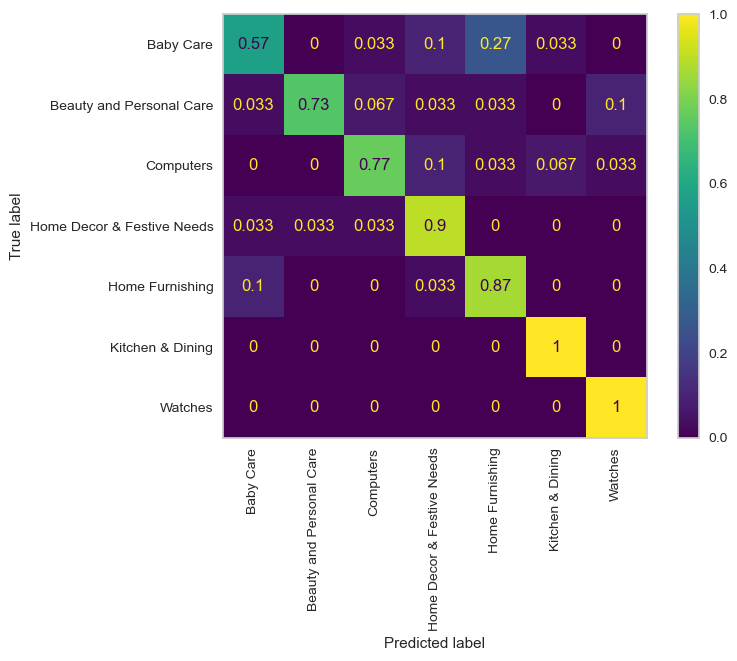

In [269]:
display_confusion_matrix(y_true, y_pred, label_names=categories)

Precision


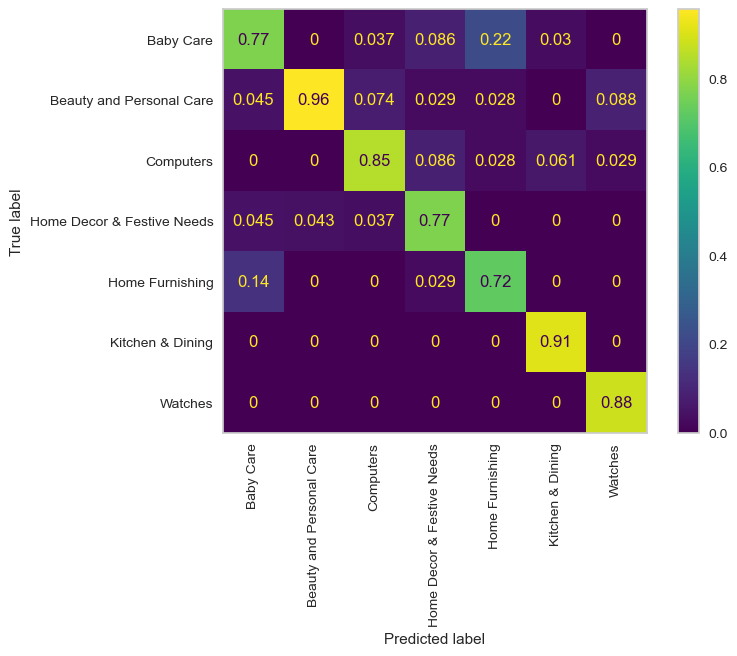

In [270]:
display_confusion_matrix(y_true, y_pred, label_names=categories, normalize='pred')

In [271]:
print(metrics.classification_report(y_true, y_pred, target_names=categories))

                            precision    recall  f1-score   support

                 Baby Care       0.77      0.57      0.65        30
  Beauty and Personal Care       0.96      0.73      0.83        30
                 Computers       0.85      0.77      0.81        30
Home Decor & Festive Needs       0.77      0.90      0.83        30
           Home Furnishing       0.72      0.87      0.79        30
          Kitchen & Dining       0.91      1.00      0.95        30
                   Watches       0.88      1.00      0.94        30

                  accuracy                           0.83       210
                 macro avg       0.84      0.83      0.83       210
              weighted avg       0.84      0.83      0.83       210



Compare 3 models accuracy and loss metrics:

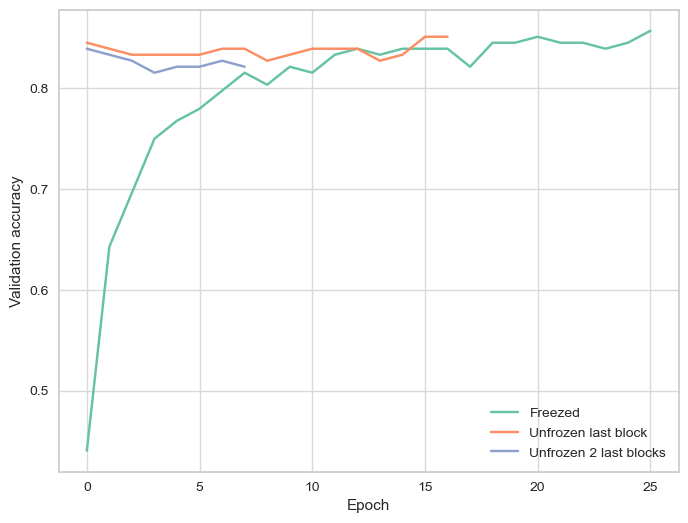

In [272]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_accuracy'], label='Freezed')
plt.plot(history_unfrozen1.history['val_accuracy'], label='Unfrozen last block')
plt.plot(history_unfrozen2.history['val_accuracy'], label='Unfrozen 2 last blocks')
plt.legend()

plt.ylabel('Validation accuracy')
plt.xlabel('Epoch')
plt.show()

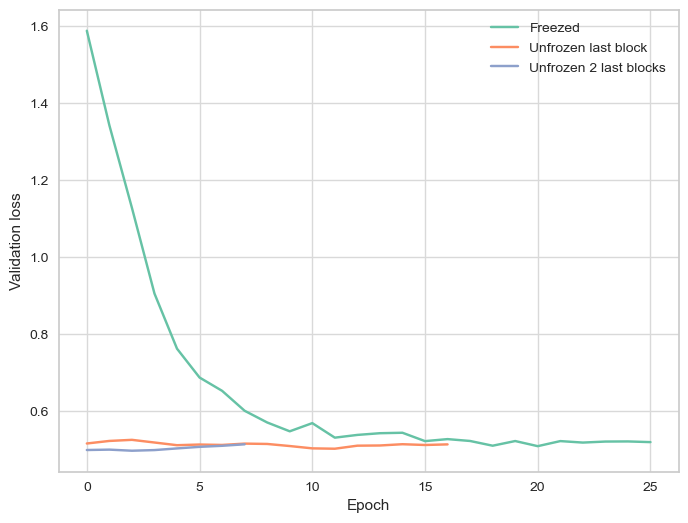

In [273]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['val_loss'], label='Freezed')
plt.plot(history_unfrozen1.history['val_loss'], label='Unfrozen last block')
plt.plot(history_unfrozen2.history['val_loss'], label='Unfrozen 2 last blocks')
plt.legend()

plt.ylabel('Validation loss')
plt.xlabel('Epoch')
plt.show()

# Conclusion

To sum up, we have applied transfer learning techniques to our classification task:
1. Feature extraction with frozen convolutional layers.
3. Fine-tuning by unfreezing last blocks of convolutional layers.

We have tested different fully connected layers setups to determine the one that gave the best accuracy scores (validation and test) and the least loss (validation and test), we then evaluated the accuracy of the classification via the confusion matrix.

We have used MLFlow to compare the best batch_size and epochs parameters.

Here is the model architecture that worked the best:

1. Data augmentation layer
2. Conv layers from ResNet50 model with frozen weights
3. Average pooling layer
4. Dense layer, 256 nodes
5. Dropout layer 0.2
6. Dense layer, 128 nodes
7. Dropout layer 0.5
8. Dense layer 7

Number of epochs: 30 <br/>
Batch size: 16

As to the fine-tuning, the best results were obtained after training the 5th (last) block of convolutional layers. However, it introduced a higher overfit, but we can try to improve it for example, by changing the Data Augmentation configuration or adjusting the Dropout layer rate setting.
